In [1]:
#%%
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
from efficientnet_pytorch import EfficientNet
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim import *

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import os, random , time, sys, math

from IPython.display import clear_output


from libs.utilities import get_freer_gpu
from libs.Model_Trainning import Model_Trainning


In [2]:
device = torch.device(get_freer_gpu()) if torch.cuda.is_available() else torch.device("cpu")
print("Device = ", device)
# model_save_path    = "data/weight/iti"

Device =  cuda:0


In [3]:
# # import albumentations as A
# # from albumentations.pytorch import ToTensorV2

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


In [6]:
image_size=229


trsfm1 = transforms.Compose([transforms.Resize((image_size,image_size)), 
                            transforms.ToTensor(),
                            transforms.Normalize( mean=(0.5,), std=(0.5,))


                                   ]) 
stim_ds1     = torchvision.datasets.ImageFolder(root='six_objects_1000stimuli', transform=trsfm1)
stim_loader1 = torch.utils.data.DataLoader(stim_ds1, batch_size = len(stim_ds1))

for idx, (imgs1, labels1) in enumerate(stim_loader1):
    if idx == 0:
        img_augment = imgs1
        y_augment   = labels1
    else:
        img_augment = torch.tensor( np.concatenate( (img_augment,imgs1), axis=0))
        y_augment   = torch.tensor( np.concatenate( (y_augment,labels1), axis=0))


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(img_augment, y_augment, test_size=0.10, random_state=42, stratify=y_augment)

In [8]:
train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)

In [9]:

batch_size = 32
train_loader = DataLoader(train_ds,
                batch_size = batch_size,
                drop_last  = False, # Drop the last batch if it is not enough for the batch size
                shuffle    = False,
                pin_memory = True)

val_loader = DataLoader(val_ds,
                batch_size = batch_size,
                drop_last  = False, # Drop the last batch if it is not enough for the batch size
                shuffle    = False,
                pin_memory = True)

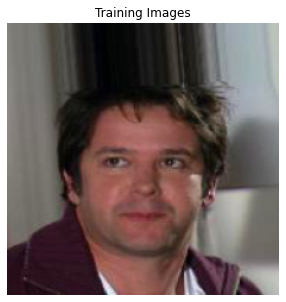

In [10]:
def grid_plot( imgs_in, figsize=(5,5) ):
    from torchvision.utils import make_grid
    
    plt.rcParams.update({'figure.max_open_warning': 0})
    grid     = make_grid(imgs_in, nrow=20, normalize=False, padding=0)
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(grid.permute(1, 2, 0).data)
    ax.axis('off')


plt.figure(figsize=(5,5))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(img_augment[600].to(device), padding=2, normalize=True).cpu(),(1,2,0)))

In [12]:

# # rand = np.random.choice(img_augment.shape[0], size=(100,)) 
# # print(rand)
# # imgs_rand = img_augment[ rand ]

# grid_plot(img_augment, figsize=(100,100))

print(img_augment.shape)



torch.Size([5997, 3, 229, 229])


In [13]:
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim

model = EfficientNet.from_pretrained('efficientnet-b0')
# for param in model.parameters():
#     param.requires_grad = False   

model._fc = nn.Sequential(
               nn.Linear(1280, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 6))

Loaded pretrained weights for efficientnet-b0


In [14]:

n_classes       = len(np.unique(y_augment))
print("n_classes :", n_classes)
print(y_augment)

n_classes : 6
tensor([0, 0, 0,  ..., 5, 5, 5])


In [17]:
criterion = nn.CrossEntropyLoss()
train_obj = Model_Trainning( model, learning_rate=0.0001, criterion=criterion )

Model train device: cuda:0
The model EfficientNet has 4,172,290 trainable parameters


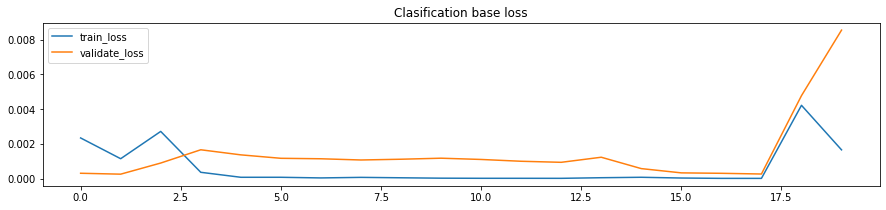

Epoch: 20/50 |	Train Loss: 0.00165   | Train Acc: 99.91%   |	 Val. Loss: 0.00854  | Val. Acc: 99.83%   |	 LR: 0.0001 |	Best epoch : 1
Actual  	: [0, 1, 0, 3, 1, 5, 0, 0, 3, 5, 1, 5, 0, 3, 1, 4, 1, 4, 3, 1, 3, 2, 3, 5]
Predicted 	: [0, 1, 0, 3, 1, 5, 0, 0, 3, 5, 1, 5, 0, 3, 1, 4, 1, 4, 3, 1, 3, 2, 3, 5]


In [ ]:
train_obj.is_plot_graph = True
train_obj.is_debug = True
train_obj.do_training( train_loader, val_loader, n_epochs=50, scheduler=None)

In [ ]:
dfasdfasdfafsdaffdd

In [ ]:
# torch.save( train_obj.state_dict()  , f'{model_save_path}' )
train_obj.save_state_dict( f'{model_save_path}' )

In [ ]:
import copy
softmax = nn.Softmax(dim=1)
for image, cat in val_loader:
    pass
print(cat)
   
image = image.to(train_obj.device)
model =   copy.deepcopy( train_obj.MODEL ) 
predicted_class =  model(image).detach()
predicted_class = torch.argmax(softmax( predicted_class ), dim=1 )
print(predicted_class)

In [17]:
print(model)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=